# image reconstruction

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [3]:
directory_data  = '/content/drive/MyDrive/2022_ml_assignment/'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']

In [4]:
print(clean_image_train.shape)
print(input_image_test.shape)
print(clean_image_test.shape)

(800, 128, 128)
(400, 128, 128)
(400, 128, 128)


## plot data

In [5]:
def plot_image(title, image):
    
    nRow = 6
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

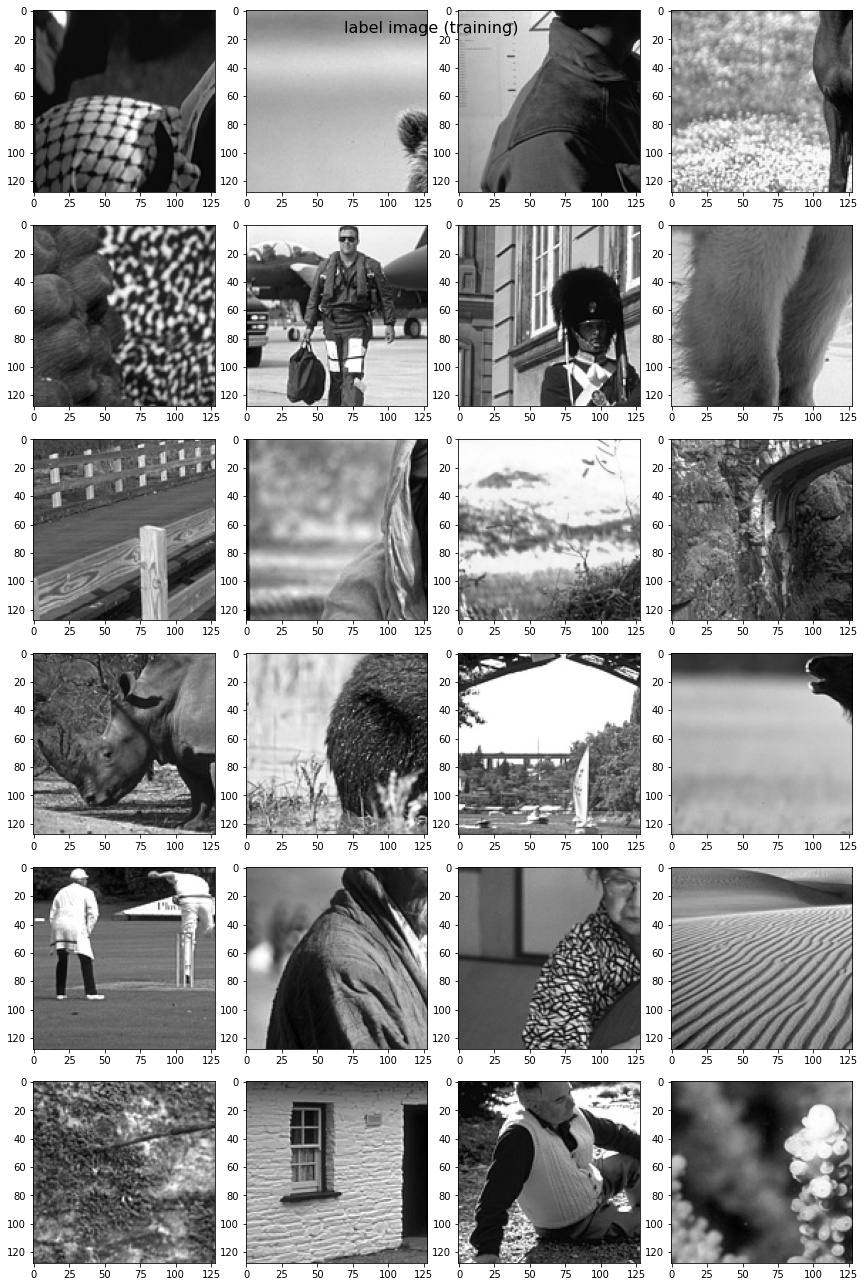

In [15]:
plot_image('label image (training)', clean_image_train)

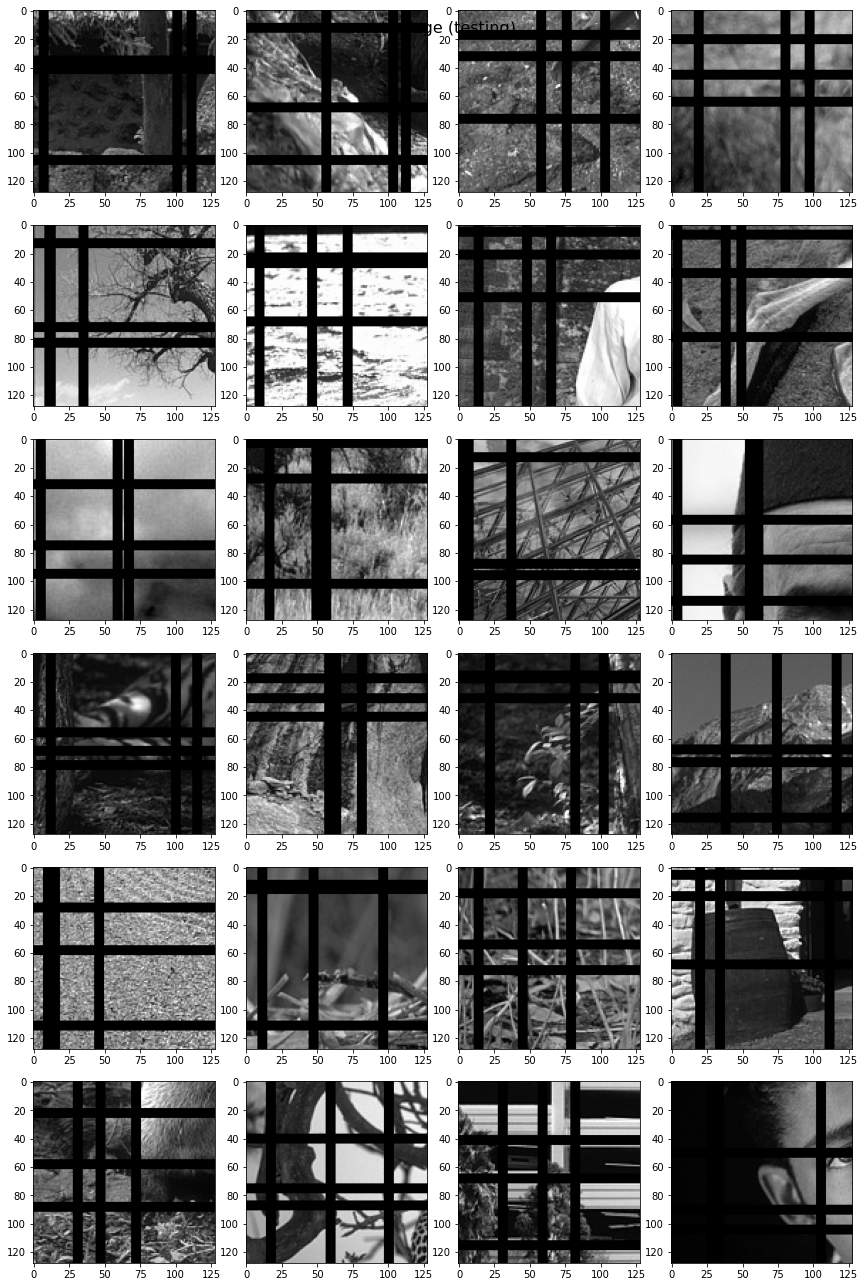

In [7]:
plot_image('input image (testing)', input_image_test)

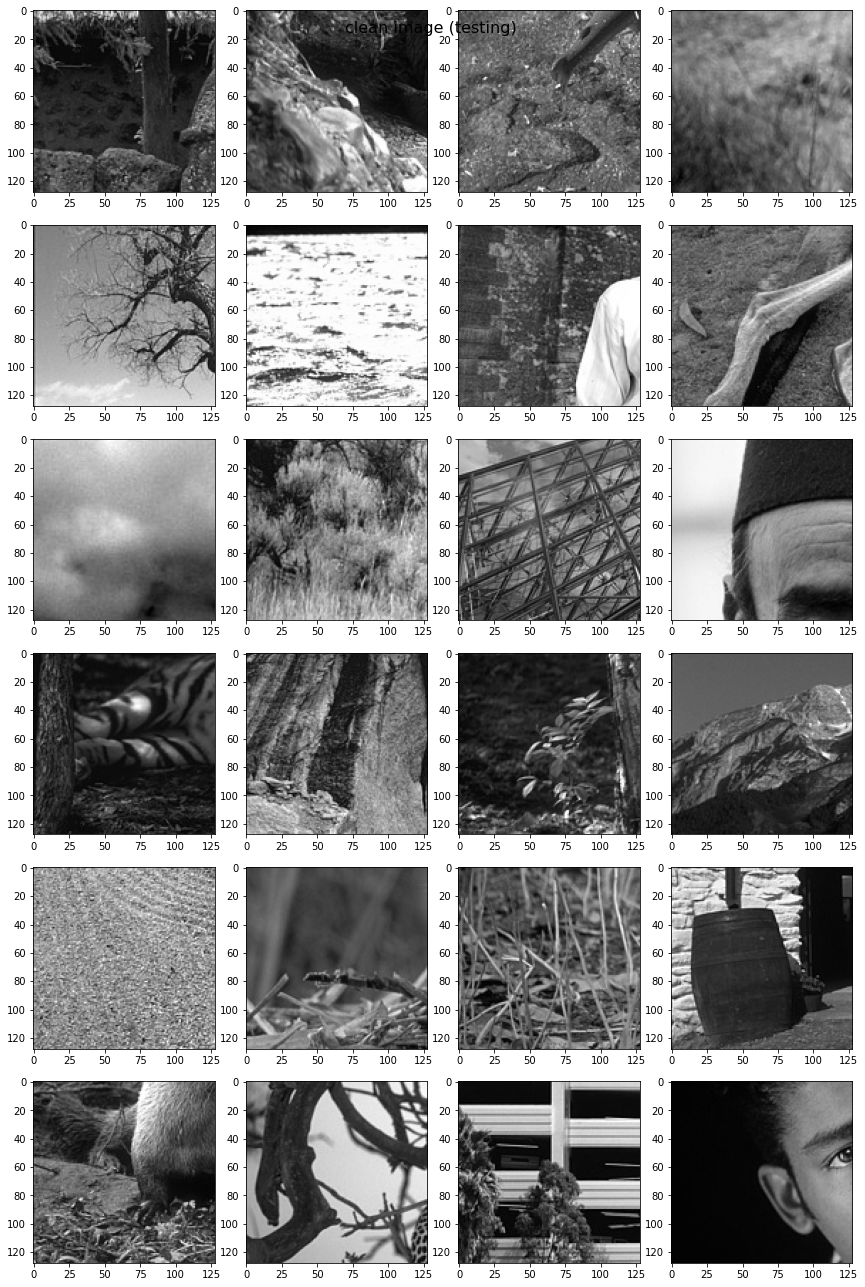

In [8]:
plot_image('clean image (testing)', clean_image_test)

## custom data loader for the training data

In [9]:
class dataset(Dataset):
    
    def __init__(self, clean_image):
        
        self.clean_image = clean_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        modified_image = clean_image.copy()
        # random integer width=6 np.random.randint(1,2)
        r1 = np.random.randint(0, 122)
        r2 = np.random.randint(0, 122)
        r3 = np.random.randint(0, 122)
        c1 = np.random.randint(0, 122)
        c2 = np.random.randint(0, 122)
        c3 = np.random.randint(0, 122)
        #row-wise
        modified_image[r1:r1+6,:] = 0
        modified_image[r2:r2+6,:] = 0
        modified_image[r3:r3+6,:] = 0
        #column-wise
        modified_image[:,c1:c1+6] = 0
        modified_image[:,c2:c2+6] = 0
        modified_image[:,c3:c3+6] = 0

        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)
        modified_image = torch.FloatTensor(modified_image).unsqueeze(dim=0)

        return (modified_image, clean_image)
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [32]:
print(device)


cuda


## custom data loader for the testing data

In [12]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

In [13]:
print(input_image_test.shape)
print(clean_image_test.shape)

torch.Size([400, 1, 128, 128])
torch.Size([400, 1, 128, 128])


## construct datasets and dataloaders for training and testing

In [46]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 100
#
# ==================================================

dataset_train       = dataset(clean_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [20]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#잠재공갠 벡터 크기
nz = 100
ngf = 64
ndf = 64
# 사용하는 이미지 채널 수
nc = 1

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.MaxPool2d(2,2),
                        nn.ReLU(),
                        nn.BatchNorm2d(2),
        )
        
        self.e_layer2 = nn.Sequential(
                        nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.MaxPool2d(2,2),
                        nn.ReLU(),
                        nn.BatchNorm2d(4),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.d_layer1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.ReLU(),
                        nn.BatchNorm2d(2),
        )
        
        self.d_layer2 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                        nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layer1,
                        self.e_layer2,
                        self.d_layer1, 
                        self.d_layer2,
        )

        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

# construct Discriminator

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# netD = Discriminator().to(device)

# # 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# # weight_init 함수를 적용
# netD.apply(weights_init)

# # 모델의 구조를 출력
# print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Construct Generator

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [22]:
# # 생성자를 생성
# netG = Generator().to(device)


# # 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# # weight_init 함수를 적용
# netG.apply(weights_init)

# # 모델의 구조를 출력
# print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## build the network

In [36]:
netD = Discriminator().to(device)
netG = Generator().to(device)

netD.apply(weights_init)
netG.apply(weights_init)
# ==================================================
# determine the optimiser and its associated hyper-parameters
#

#loss function setting
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

learning_rate = 0.001
number_epoch = 50
# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

#
# ==================================================

## compute the prediction

In [26]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [27]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [37]:
psnr_test = np.zeros(number_epoch)

## train

In [47]:
def train(netD, netG, optimizerD, optimizerG, dataloader):

    netD.train()
    netG.train()

    # ==================================================
    # fill up the blank
    #
    for i, (modified, original) in enumerate(dataloader):
        
        ## 진짜 데이터들로 학습
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정
        real_cpu = original.to(device)
       
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        print("001")
        # 진짜 데이터들로 이루어진 배치를 D에 통과
        output = netD(real_cpu).view(-1)
        print("11")
        # 손실값을 구함
        errD_real = criterion(output, label)
        print("22")
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        print("33")
        D_x = output.mean().item()
        
        ## 가짜 데이터들로 학습
        # 생성자에 사용할 잠재공간 벡터를 생성
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()
        
         # (2) G 신경망을 업데이트 : log(D(G(z)))를 최대화 
        
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

         # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())


## test

In [34]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [48]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    train(netD, netG, optimizerD, optimizerG, dataloader_train)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(netG, input_image_test, clean_image_test)
    psnr_test[i]    = psnr

  0%|          | 0/50 [00:00<?, ?it/s]

001


  0%|          | 0/50 [00:00<?, ?it/s]

11


ValueError: ignored

---

## functions for presenting the results

---

In [ ]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_02():
   
    nRow = 9
    nCol = 4
    size = 3
   
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    model.eval()

    num_test = 12

    input_image         = input_image_test[0:num_test]
    clean_image         = clean_image_test[0:num_test]
    prediction_image    = compute_prediction(model, input_image)
   
    input_image         = input_image.detach().cpu().squeeze(axis=1)
    clean_image         = clean_image.detach().cpu().squeeze(axis=1)
    prediction_image    = prediction_image.detach().cpu().squeeze(axis=1)

    nStep   = 3
    t       = 0
   
    for r in range(3):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
           
            input       = input_image[t].detach().cpu().squeeze(axis=1)
            clean       = clean_image[t].detach().cpu().squeeze(axis=1)
            prediction  = prediction_image[t].detach().cpu().squeeze(axis=1)
           
            axes[0 + r * nStep, c].imshow(input, cmap='gray')
            axes[1 + r * nStep, c].imshow(clean, cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(prediction, cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
           
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)
           
            t = t + 1
   
    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



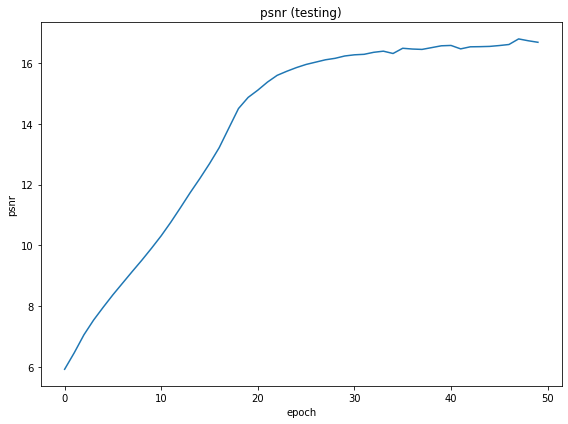


################################################################################
#
# RESULT # 02
#
################################################################################



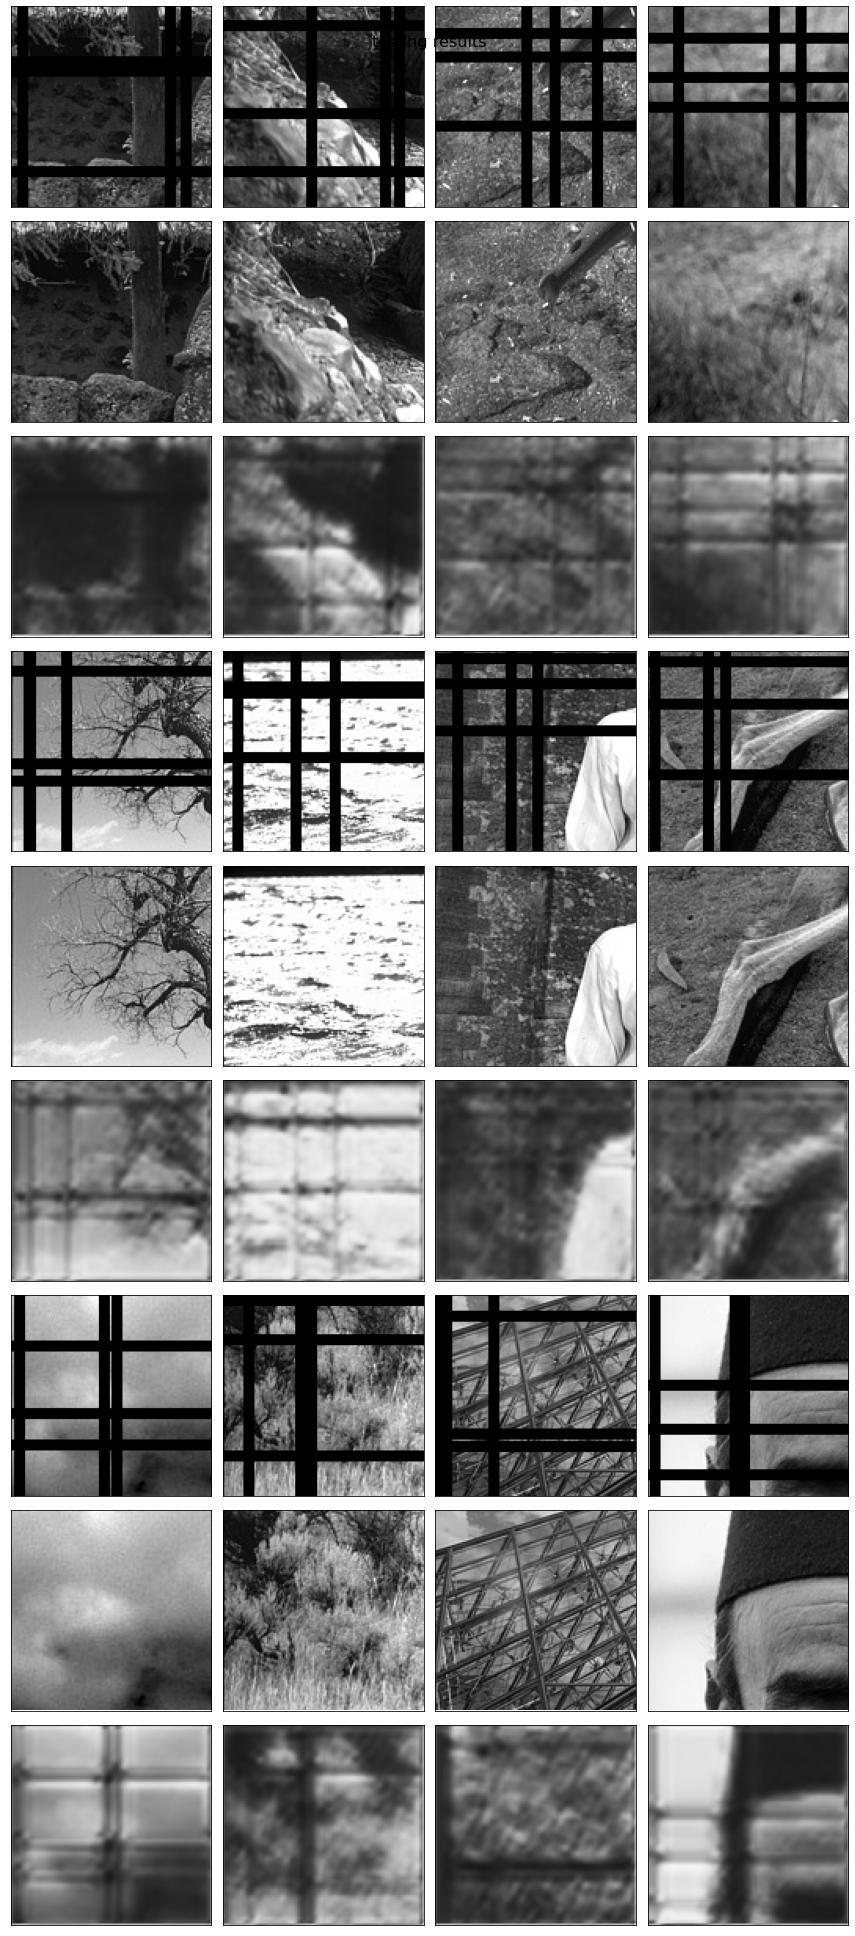


################################################################################
#
# RESULT # 03
#
################################################################################

final testing psnr = 16.67917164


In [ ]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)